# Powerfolio!

<img src="images/logo.png" width="150" title="stock_flex" align="center">

---

### Import Dependancies
Import system, data analytics, finance API, database tools, and visualization libraries

In [1]:
# System
import os
import time, sys
from pathlib import Path
from dotenv import load_dotenv
import requests
from datetime import date, datetime, timedelta
from ast import literal_eval as make_tuple

# Data analytics
import pandas as pd
from pandas import DataFrame, MultiIndex
from typing import List, NewType
import numpy as np

# Visualization
import panel as pn
import panel.widgets as pnw
import plotly.express as px
import plotly.graph_objects as go
pn.extension('plotly')
pn.extension()
import holoviews as hv
import hvplot.pandas
import matplotlib.pyplot as plt

# Finance
import alpaca_trade_api as tradeapi
import quandl as ql
import finnhub

import warnings
warnings.filterwarnings('ignore')

# Local dependancies
import MyPortfolioSimulator

### API and static data file paths

In [2]:
API_KEYS_FILE_PATH = Path("../resources/api_keys.env")
TICKERS_CSV = Path("resources/sp500_tickers.csv")
FUNDAMENTAL_DATA_PATH = Path("resources/fundamental_data.csv")

---

## Data Connections
- Static Data Connections
- Dynamic Data Connections

### Static Data Connections

##### Stock Ticker Lists

In [3]:
# Get tickers within S&P500 index
sp500_tickers_path = Path(TICKERS_CSV)
sp500_tickers = pd.read_csv(sp500_tickers_path).sort_values(by="Symbol")

#### Fundamental Data List

In [4]:
# Get fundamental data from csv
stock_fundamentals_data_path = Path(FUNDAMENTAL_DATA_PATH)
stock_fundamentals_df = pd.read_csv(stock_fundamentals_data_path)

### Dynamic Data Connections

#### Stock Price Data

In [5]:
# Alpaca API connector
load_dotenv(API_KEYS_FILE_PATH)

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
alpaca_api_key,
alpaca_secret_key,
api_version = "v2"
)

#### Fundamental Stock Data

In [6]:
# FinnHub API connector
load_dotenv(API_KEYS_FILE_PATH)

# Set FinnBug API key
finnhub_api_key = os.getenv("FINNHUB_API_KEY")

# Create FinnHub API object
finnhub_client = finnhub.Client(api_key=finnhub_api_key)

# Method to obtain json data from Polygon API
def finnhub_data(ticker):
    
    data = finnhub_client.company_basic_financials(ticker, "")
    data_df = pd.DataFrame(data)
    time.sleep(1)
    
    return data_df

#### Bond Data

In [7]:
# Treasury bonds
def treasury_data():
    return ql.get("USTREASURY/YIELD")

---

## Data Parsing

##### Stock Data Parsing Methods
A collection of methods for parsing S&P 500 tickers, calling Alpaca Trade API, and querying stock_prices.db database

#### Alpaca API Methods

In [8]:
# Get prices for tickers withing a given index or sector
def stock_prices_from_api(ticker_list, start_date, end_date):
    '''Returns pd.DataFrame with prices for the given tickers
    
    ...
    
    Parameters
    ----------
    tickers_df : pd.DataFrame - contains tickers for given index or sector under 
        the "Symbol" column which is the DataFrame key
    start_date : str() - string with date in following format YYYY-MM-DD
    end_date: str() - string with date in following format YYYY-MM-DD 
    
    
    Returns
    -------
    result_df : pd.DataFrame with securities price data
    '''
   
    # Get list of tickers from the tickers_df list or tickers_df DataFrame 
    tickers = ticker_list
    
    # Parse start and end dates
    start_date = pd.Timestamp(start_date, tz="America/New_York").isoformat()
    end_date = pd.Timestamp(end_date, tz="America/New_York").isoformat()
    
    # Connect to Alpaca API and get data
    """Condition handling: 
        a. Alpaca API 422 Client Error if more than 100 tickers are passed - COMPLETE
        b. Alpaca API data max row limit of 1000 - PENDING"""
    
    
    # a. Alpaca API condition handling, sending 100 tickers at a time
    # Declate a pd.DataFrame
    result_df = pd.DataFrame()
    tickers_n = 50
    
    for i in range(0, len(tickers), tickers_n):
        # Slice the ticker list into lists of 50 tickers
        sliced_tickers = tickers[i:i + tickers_n] 
        
        temp_df = api.get_barset(
        sliced_tickers,
        timeframe = "1D",
        start = start_date,
        end = end_date,
        limit = 1000).df

        # Append temporary dataframe to result_df
        result_df = pd.concat([result_df, temp_df], axis = "columns", join = "outer")
        time.sleep(0.1)
        
    return result_df

---

## Technical Methods

Technical analysis methods: 
- RSI 
- MACD 

### Technical Data Methods

##### RSI - Relative Strenght Index

In [9]:
# RSI method : Calculate the RSI indicator
def rsi_table (df, days):
    '''Returns a pd.DataFrame with Relative Strength Index (RSI) column appended
        RSI formula = 100 – (100 / (1 + RS) or can also use 100 * up / (Up + Down)
        Where RS (relative strengh)  = Up / Down
        Where Up = rolling average price up over the time window obeserved
        Where Down = rolling average price down over the time window obeserved
    
        Parameters
        ----------
        df : pd.DataFrame - dataframe to be processed
        days : int() - numbers of days for RSI calcualtion
    
        Returns
        -------
        result_df : pd.DataFrame - dataframe with RSI column appended, calcualted daily for 
        timeperiod specified by days
    '''
    
    # Filter datafrance to clumn "close" only to facilitate the calculs
    stocks_close = df.iloc[:,df.columns.get_level_values(1)=='close']
    # Swap the column multilevel index to facilitate the calculs
    stocks_close = stocks_close.swaplevel(0,1,axis=1)
    
    # Calculate the movement on the price compared to the previous day closing price
    movement_1d = stocks_close - stocks_close.shift(1)
    movement_1d.rename(columns={'close':'movement_1d'}, level=0, inplace=True)

    # Define a sub-function to calculate the RSI
    def rsi (price):
        up = price[price>0].mean()
        down = abs(price[price<0]).mean()
        return 100 * up / (up + down)
        
    # Calculate the RSI and add it to a dataframe
    rsi_df = movement_1d.rolling(window=days).apply(rsi)
    rsi_df.rename(columns={'movement_1d':'RSI'}, level=0, inplace=True)
    
    # Remove the first dates that return NaN from the rolling days calculation
    rsi_df = rsi_df[days:]

    return rsi_df

##### MACD - Moving Average Convergence/Divergence

In [10]:
# MACD method : Calculate the MACD indicator with its Signal line
def macd_table(df, short_window, long_window, signal_window):
    ''' Moving Average Convergence Divergence (MACD) 
        Returns a pd.DataFrame with MACD and its Signal line column appended
        MACD formula = (12-day EMA - 26-day EMA)
        Signal line = MACD 9-day EMA
    
        Parameters
        ----------
        df : pd.DataFrame - dataframe to be processed
        short_ema : int() - short-term EMA for MACD calculation => default should be 12 days
        long_ema : int() - long-term EMA for MACD calculation => defaultshould be 26 days

        Returns
        -------
        result_df : pd.DataFrame - dataframe with MACD and Signal line column appended, calcualted daily for 
        timeperiod specified by days
    '''

    # Filter datafrance to clumn "close" only to facilitate the calculs
    stocks_close = df.iloc[:,df.columns.get_level_values(1)=='close']
    stocks_close = stocks_close.swaplevel(0,1,axis=1)
    
    # Define a sub-function to calculate the MACD
    def macd (price):
        short_ema = price.ewm(span=short_window, adjust=False).mean()
        long_ema = price.ewm(span=long_window, adjust=False).mean()
        macd_value = short_ema - long_ema
        return macd_value
    
    # Calculate the MACD and add it to a dataframe
    macd = stocks_close.apply(macd)
    macd.rename(columns={'close':'MACD'}, level=0, inplace=True)

    # Calculate the Signal line value
    signal = macd.ewm(span=9, adjust=False).mean()
    signal.rename(columns={'MACD':'MACD_Signal'}, level=0, inplace=True)
    
    # Concatenate/append both indicators to a new dataframe
    result_df = pd.concat([macd, signal], axis=1, join='inner')

    return result_df

### RSI Trader

In [11]:
def rsi_trader(tickers_list : list(), 
               lower_level : int(), 
               upper_level : int(), 
               start_date : str(), 
               end_date : str(), 
               rsi_range : int()):
    '''Returns a pd.DataFrame of a portoflio where position entry and exit are 
        determined by Relative Strength Index (RSI) values provided by the user.
    
        Parameters
        ----------
        tickers_list : list() - list of tickers to be traded
        lower_level : int() - lower level of RSI provided by user
        upper_level : int() - upper level of RSI provided by user
        start_date : str() - analysis start date string "YYYY-MM-DD"
        end_date : str() - analysis end date string "YYYY-MM-DD"
        rsi_range : int() - numbers of days for RSI calcualtion
    
        Returns
        -------
        result_df : pd.DataFrame - RSI traded portfolio
    '''
    
    # Get stock prices form Alpaca Trade API
    stock_prices = stock_prices_from_api(tickers_list, start_date, end_date)
    
    # Collapse multi-index to yield a single-index df with 'close' prices
    try:
        formatted_stock_prices = stock_prices.xs('close', axis=1, level=1, drop_level=False).droplevel(1, axis=1)
    except:
        formatted_stock_prices = pd.DataFrame({'time' : [datetime.strptime('2020-01-01', "%Y-%m-%d")], 'close' : [0.0]})
        print("RSI Portfolio Builder received an empty pd.DataFrame of stock prices")
        raise 

    # Declare RSI df
    rsi_df = pd.DataFrame()   
    
    # Declare arbitrary cash position df and seed it
    cash_seed = 1000000.0
    cash_position = {}
    cash_position[0] = {'time' : formatted_stock_prices.index[0], 'close' : cash_seed}
    
    # Track long stock positions
    long_stock_position_tracker = {}
    for ticker in tickers_list:
        long_stock_position_tracker[ticker] = False
    
    # Build RSI trader positions over time
    ## iterate ticker colums
    for ticker in tickers_list:
        
        ### Declate dict for stock positions
        stock_seed = 0.0
        stock_position = {}
        stock_position[0] = {'time' : formatted_stock_prices.index[0], 'close' : stock_seed, 'rsi' : 0, 'stock_price' : 0, 'cash' : cash_seed/len(tickers_list)}
        
        ### generate df for ticker
        ticker_df = pd.DataFrame(formatted_stock_prices[ticker]).reset_index()

        # Calculate RSI
        delta = ticker_df[ticker].diff()
        move_up = delta.clip(lower=0)
        move_down = -1*delta.clip(upper=0)
        ema_up = move_up.ewm(com=rsi_range, adjust=False).mean()
        ema_down = move_down.ewm(com=rsi_range, adjust=False).mean()
        relative_strenght = ema_up/ema_down
        
        # add RSI to df
        ticker_df['rsi'] = 100 - (100/(1 + relative_strenght))
        
        # Skip first 14 days
        ticker_df = ticker_df.iloc[14:]   
    
        #### iterate over the trading days
        for day in range(len(ticker_df.index)):
            ### get data for previous and current days and get RSI
            date = ticker_df.iloc[day,:]['time']
            stock_price = ticker_df.iloc[day,:][ticker]
            previous_day_rsi  = float(ticker_df.iloc[day-1, 2])
            current_day_rsi = float(ticker_df.iloc[day, 2])

            #### Trade logic - Open Long Position
            if previous_day_rsi < float(lower_level) and current_day_rsi > float(lower_level):

                ##### Check if long stock -> pass
                if long_stock_position_tracker[ticker] == True:
                    ## Adjust position
                    stock_position[day] = {'time' : date, 'close' : stock_position[day-1]['close'], 'rsi' : current_day_rsi,  'stock_price' : stock_price, 'cash' : stock_position[day-1]['cash']}


                #### Check if not long stock -> Go long
                elif long_stock_position_tracker[ticker] == False:
                    # Long position entry triggered

                    ## Adjust position
                    stock_adj = (cash_seed/len(tickers_list))/stock_price
                    cash_adj = 0

                    stock_position[day] = {'time' : date, 'close' : stock_adj, 'rsi' : current_day_rsi,  'stock_price'  : stock_price, 'cash' : cash_adj}

                    long_stock_position_tracker[ticker] = True

            ### Trade Logic - Close Long Position
            elif previous_day_rsi > float(upper_level) and current_day_rsi < float(upper_level):

                #### Check if not long stock -> pass
                if long_stock_position_tracker[ticker] == False:
                    ## Adjust position
                    try:
                        stock_position[day] = {'time' : date, 'close' : stock_position[day-1]['close'], 'rsi' : current_day_rsi,  'stock_price' : stock_price, 'cash' : stock_position[day-1]['cash']}
                    except:
                        stock_position[day] = {'time' : date, 'close' : 0, 'rsi' : current_day_rsi,  'stock_price' : stock_price, 'cash' : cash_seed/len(tickers_list)}

                #### Check if long stock -> Close long
                if long_stock_position_tracker[ticker] == True:
                    # Long position exit triggered
                    ## Adjust cash position
                    cash_adj = stock_position[day-1]['cash'] + stock_position[day-1]['close'] * stock_price
                    stock_adj = 0

                    stock_position[day] = {'time' : date, 'close' : stock_adj, 'rsi' : current_day_rsi,  'stock_price' : stock_price, 'cash' : cash_adj}

                    long_stock_position_tracker[ticker] = False

            ### Trade Logic - No Trade
            else:
                ## Adjust position
                try:
                    stock_position[day] = {'time' : date, 'close' : stock_position[day-1]['close'], 'rsi' : current_day_rsi,  'stock_price' : stock_price, "cash" : stock_position[day-1]['cash']}
                except:
                    stock_position[day] = {'time' : date, 'close' : 0, 'rsi' : current_day_rsi,  'stock_price'  : stock_price, 'cash' : cash_seed/len(tickers_list)}
                

        # Transpose stock_position_df   
        stock_position_df = pd.DataFrame(stock_position).transpose()
        
        # Set index to tim
        stock_position_df = stock_position_df.set_index('time')
        
        # Calculate stock_position_df positon value
        stock_position_df[ticker] = (stock_position_df['close'] * stock_position_df['stock_price']) + stock_position_df['cash']
        
        # Concatentate stock_position_df into master df
        rsi_df = pd.concat([rsi_df,stock_position_df[ticker]], axis='columns', join='outer')
    
    # Get total portfolio value
    rsi_portfolio_sum = rsi_df.sum(axis=1)/cash_seed-1

    return rsi_portfolio_sum

---

## FundamentalMethods

Fundamental analysis methods
- PE - Price to earnings ratio
- EPS - Earnings per share
- Dividend

### Fundamental Data Methods

In [12]:
# Get stock fundamental data from FinnHub
def generate_stock_fundamentals_from_finnhub(tickers_df):
    '''Returns pd.DataFrame with fundamentals of tickers within tickers_df
    
    ...
    Parameters
    ----------
    tickers_df : pd.DataFrame - contains tickers for given index or sector under 
        the "Symbol" column which is the DataFrame key
        
    Returns
    -------
    result_df : pd.DataFrame - securities fundamental data
    '''
    
    result_df = pd.DataFrame()
    
    for ticker in tickers_df['Symbol']:
        fundamental_data = finnhub_data(ticker)
        result_df = pd.concat([result_df, fundamental_data], axis='rows', join="outer")
        
    # Parse the dataframe
    result_df = result_df.reset_index().set_index('symbol')
    result_df = result_df.drop('metricType', 1)
    result_df.columns = ['metric_type', 'metric', 'series']
    
    return result_df


# Refresh stock fundamental data csv
def refresh_fundamentals_csv(tickers_df):
    '''Helper method - returns pd.DataFrame with fundamentals of tickers within tickers_df
    and/or calls to generate a refreashed dataset.
    
    Generates a CSV file with updated Fundamental values
    
    ...
    Parameters
    ----------
    tickers_df : pd.DataFrame - contains tickers for given index or sector under 
        the "Symbol" column which is the DataFrame key
    '''
    result_df = generate_stock_fundamentals_from_finnhub(tickers_df)
    result_df.to_csv("resources/fundamental_data.csv", mode='w')
    

# Fundamental data filter
def fundamental_data_query(tickers_df, stock_fundamentals_df, fundamental_indicator_keys):
    '''Returns a pd.DataFrame of fundamental data filtered by user input range
    
    ...
    
    Parameters
    ----------
    tickers_df : pd.DataFrame - dataframe to be processed, contains tickers
    fundamental_indicator_key : str() - keyword for fundamental indicator requested
    
        Fundamental indicator keys ->
        
        P/E Ratio : [pe_ratio]
        EPS (Earnings per Share) : [eps]
        Annual Dividend : [dividend]
        Beta (vs. S&P 500) : [beta]
        EBIDT : [ebidt]
        Quick Ratio : [quick_ratio]
        3 Year Revenue Growth : [rev_growth]
        Free Cash Flow : [cash_flow]
    
    lower_bound : int() or float() - lower bound for fundamental value filter, default = -1000000
    upper_bound : int() or float() - upper bound for fundamental value filter, default = 1000000
     
    Returns
    -------
    result_df : pd.DataFrame - dataframe with ticker and filtered fundamental data
    '''

    fund_indicators_dict = {
        'pe_ratio' : 'peNormalizedAnnual',
        'eps' : 'epsNormalizedAnnual',
        'dividend' : 'dividendsPerShareTTM',
        'beta' : 'beta',
        'ebidt' : 'ebitdPerShareTTM',
        'quick_ratio' : 'quickRatioAnnual',
        'rev_growth' : 'revenueGrowth3Y',
        'free_cash_flow' : 'freeCashFlowAnnual'   
    }

    # Declare result_df
    result_df = pd.DataFrame()
    
    # Declate tickers list
    tickers_list = tickers_df['Symbol']
    
    # Declare fundamental data df and filter by ticker df
    data_df = stock_fundamentals_df[stock_fundamentals_df.symbol.isin(tickers_list)]
    data_df = data_df.set_index(['symbol'])
    
    # Extract requested fundamental data
    for ind in fundamental_indicator_keys:
        df = data_df[data_df['metric_type'] == fund_indicators_dict[ind]]
        result_df = pd.concat([result_df, df], axis = 1, join = 'outer')
    
        # Clean up df
        result_df = result_df.drop(columns = ['metric_type', 'series'])
        result_df = result_df.rename(columns = {'symbol' : 'ticker', 
                                'metric' : ind})
        
            # Convert all df values to numeric
        result_df[ind] = result_df[ind].apply(pd.to_numeric)
    
    return result_df

### Fundamental Portfolio Methods

In [13]:
# Generate pd.DataFrame of fundamental values needed for Dashboard filtering
fundamental_values = fundamental_data_query(sp500_tickers, stock_fundamentals_df, ['eps', 'pe_ratio', 'dividend','ebidt','quick_ratio','rev_growth','free_cash_flow'])

In [14]:
# Filter stocks by Dashboard selection
def filter_stocks_by_fundamentals(pe_range: tuple, 
                                  eps_range: tuple,
                                  dividend_range: tuple):
    '''Returns pd.DataFrame with filtered stocks by user criteria
    
    ...
    Parameters
    ----------
    pe_range : tuple - contains float()'s with user defined PE range
    epn_range : tuple - contains float()'s with user defined EPS range
    dividend_range : tuple - contains float()'s with user defined Dividend range
        
    Returns
    -------
    result_df : pd.DataFrame - dataframe with ticker and filtered fundamental data
    '''
    
    # Filter PE and EPS
    min_pe = pe_range[0]
    max_pe = pe_range[1]
    
    min_eps = eps_range[0]
    max_eps = eps_range[1]
    
    min_dividend = dividend_range[0]
    max_dividend = dividend_range[1]
    
    # Filer fundamental_values dataframe by value range
    result_df = fundamental_values[(fundamental_values['eps'] >= min_eps) & 
                                   (fundamental_values['eps'] <= max_eps) & 
                                   
                                   (fundamental_values['pe_ratio'] >= min_pe) & 
                                   (fundamental_values['pe_ratio'] <= max_pe) &
                                   
                                   (fundamental_values['dividend'] >= min_dividend) & 
                                   (fundamental_values['dividend'] <= max_dividend)
                                  ]
    
    return result_df


# List of dates between two user selected dates
def list_of_dates_between_two_dates(start_date: str,
                                    end_date: str):  
    '''
    Helper function to ger a range of dates between two dates
    '''
    return (pd.date_range(start_date, end_date-timedelta(days=1), freq='d').strftime("%Y-%m-%d").to_list())


# Build fundamental portfolio
def get_fundamental_portfolio(ticker_list,
                                start_date: str = "2020-01-01", 
                                end_date: str = "2021-05-01"):
    '''Returns pd.DataFrame weighted cumulative product portfolio
    
    ...
    Parameters
    ----------
    ticker_list : list - contains tickers to be processed
    start_date : str() - analysis start date string "YYYY-MM-DD"
    end_date : str() - analysis end date string "YYYY-MM-DD"
        
    Returns
    -------
    result_df : pd.DataFrame - dataframe with ticker and filtered fundamental data
    '''
    
    # Get stock prices for given stocks 
    stock_prices = stock_prices_from_api(ticker_list, start_date, end_date)
    
    idx = pd.IndexSlice
    index = list(stock_prices.transpose().index.get_level_values(0))
    try:
        formatted_stock_prices = stock_prices.xs('close', axis=1, level=1, drop_level=False).droplevel(1, axis=1)
    except:
        formatted_stock_prices = pd.DataFrame({'time' : ['2020_01_01'], 'close' : [0.0]})
    
    # For equal weight portfolio
    ntickers = len(ticker_list)
    weights = np.full(ntickers, (1.0 / ntickers))
    
    
    equal_weighted_portfolio = formatted_stock_prices.pct_change().dot(weights).cumsum().dropna()
        
    return equal_weighted_portfolio

## Data Visualization

### Powerfolio! Dashboard

#### Heading

In [15]:
# Color palatte
background_color = "WhiteSmoke"

# Dashboard title
title_panel = pn.Row(
    pn.panel("images/logo.png", height=60),
    pn.Column("#Powerfolio!", width=1000),
    pn.Spacer(background=background_color, sizing_mode='stretch_both'),
    width_policy='max',
    sizing_mode='stretch_both',
    background=background_color)

#### Welcome to Powerfolio! Tab

In [16]:
welcome_message = pn.Column("Powerfolio! Implements:",
                           " - fundamental analysis (P/E, EPS, Dividend)",
                           " - technical analysis (RSI, MACD)",
                           " - traditional  portfolio analysis (Sharpe Ratio, Efficient Frontier)",
                          "to turn your portfolio into a power-folio!")

# Loading bars
fundamental_refresh_loading_bar = pn.indicators.Progress(name='Progress', active=False, width=200, bar_color = 'primary')
offline_db_loading_bar = pn.indicators.Progress(name='Progress', active=False, width=200, bar_color = 'danger')

#####################################################################

# Refresh fundamentals button
btn_refresh_fundamental_data_descriptor = "Refreshes stock fundamental data for S&P 500 from FinnHub (API key required) <br><br> This may take 5-10 minutes"
btn_refresh_fundamental_data = pn.widgets.Button(name='Refresh Fundamentals', button_type='primary', width=200)

# Refresh fundamentals button event method
def refresh_fundamental_data_event(event):
    fundamental_refresh_loading_bar.active = True
    refresh_fundamentals_csv(sp500_tickers)
    fundamental_refresh_loading_bar.active = False
    
## Refresh fundamentals button on-click
btn_refresh_fundamental_data.on_click(refresh_fundamental_data_event)

#####################################################################

# Welcome to Powerfolio! tabs
welcome_to_powerfolio = pn.Column(
    welcome_message,
    pn.layout.Divider(margin=(0, 0, 0, 0)),
    
    
    pn.Column("## Refresh Fundamental Data",
              btn_refresh_fundamental_data_descriptor,
              pn.Row(btn_refresh_fundamental_data, fundamental_refresh_loading_bar),
              pn.layout.Divider(margin=(+5, 0, 0, 0)))
)

#### Fundamental Portfolio Dashboard

In [17]:
# Fundamental value filter
fundamental_filter_title = pn.panel("### Fundamental Stock Selector")

In [18]:
## Generate date range for DatePicker
date_range = list_of_dates_between_two_dates(date.fromisoformat('2015-01-01'),
                                             date.fromisoformat(datetime.today().strftime("%Y-%m-%d")))


## DatePicker - selects date range for simlated portfolio
datepicker_date_start_date_selector = pn.widgets.DatePicker(name="Start Date:", enabled_dates=date_range, width=100)
datepicker_date_end_date_selector = pn.widgets.DatePicker(name="End Date:", enabled_dates=date_range, width=100)




In [19]:
# PE filter
## Get PE value range
min_pe_value =  round(float(fundamental_values['pe_ratio'].min()),2)
max_pe_value =  round(float(fundamental_values['pe_ratio'].max()),2)

## TextInput - input minimum and maximum PE values
text_input_min_pe_values = pn.widgets.TextInput(name='Min', max_width=70, placeholder = str(min_pe_value))
text_input_max_pe_values = pn.widgets.TextInput(name='Max', max_width=70, placeholder = str(max_pe_value))



# EPS filter
## Get EPS value range
min_eps_value = round(float(fundamental_values['eps'].min()),2)
max_eps_value = round(float(fundamental_values['eps'].max()),2)

## Text Input - input minimum and maximum EPS values
text_input_min_eps_values = pn.widgets.TextInput(name='Min', max_width=70, placeholder = str(min_eps_value))
text_input_max_eps_values = pn.widgets.TextInput(name='Min', max_width=70, placeholder = str(max_eps_value))



# Dividend filter
## Get Divident value range
min_dividend_value = round(float(fundamental_values['dividend'].min()),2)
max_dividend_value = round(float(fundamental_values['dividend'].max()),2)

## TextInput - input minimum and maximum Dividend values
text_input_min_dividend_values = pn.widgets.TextInput(name='Min', max_width=70, placeholder = str(min_dividend_value))
text_input_max_dividend_values = pn.widgets.TextInput(name='Min', max_width=70, placeholder = str(max_dividend_value))

In [20]:
# Declare filtered_fundamental_stocks_df and populate with all stocks
filtered_fundamental_stocks_df = filter_stocks_by_fundamentals((min_pe_value, max_pe_value),
                                                               (min_eps_value, max_eps_value),
                                                               (min_dividend_value, max_dividend_value)
                                                              )

# Generate fundamental stock viewer DataFrame view 
fundamental_stocks_dataframe_viewer = pn.widgets.DataFrame(filtered_fundamental_stocks_df, 
                                                           name='Filtered Stocks',
                                                           sortable=True,
                                                           autosize_mode='fit_viewport',
                                                           frozen_columns=0,
                                                           height=350
                                                          )

In [21]:
# Filtered fundamentals dataframe
global fundamental_stocks_dataframe
global fundamental_stock_portfolio


# Button - filteres stocks by user selected fundamental values
btn_update_fundamental_stocks_dataframe_viewer = pn.widgets.Button(name='Apply selection', button_type='primary')


# Fundamental portfolio plot
fundamental_stock_portfolio = pd.DataFrame({'time' : [datetime.strptime('2020-01-01', '%Y-%m-%d')], 
                                           'close' : [0.0]})

fundamental_portfolio_plot =  fundamental_stock_portfolio.hvplot(x='time',
                                                                 y='close',
                                                                 title='Portfolio',
                                                                 ylabel='Portfolio Returns, %',
                                                                 height=700,
                                                                legend='right')

fundamental_technical_portfolio_plot_panel = pn.panel(fundamental_portfolio_plot)

# Refresh filtered stock results and dtaframe display
def update_fundamental_stocks_dataframe_viewer(event):
    global fundamental_stocks_dataframe
    
    min_pe_range_selected = min_pe_value
    max_pe_range_selected = max_pe_value
    min_eps_range_selected = min_eps_value
    max_eps_range_selected = max_eps_value
    min_dividend_range_selected = min_dividend_value
    max_dividend_range_selected = max_dividend_value
    
    # set user defined RSI values
    if text_input_min_pe_values.value != "":
        min_pe_range_selected = float(text_input_min_pe_values.value)
        
    if text_input_max_pe_values.value != "":
        max_pe_range_selected = float(text_input_max_pe_values.value)
    
    
    # set user defined EPS values
    if text_input_min_eps_values.value != "":
        min_eps_range_selected = float(text_input_min_eps_values.value)
        
    if text_input_max_eps_values.value != "":
        max_eps_range_selected = float(text_input_max_eps_values.value)

    
    # set user defined Devidend values
    if text_input_min_dividend_values.value != "":
        min_dividend_range_selected = float(text_input_min_dividend_values.value)
        
    if text_input_max_dividend_values.value != "":
        max_dividend_range_selected = float(text_input_max_dividend_values.value)

    
    # Filter stocks by fundamental values input by user
    fundamental_stocks_dataframe = filter_stocks_by_fundamentals((min_pe_range_selected, max_pe_range_selected), 
                                                                 (min_eps_range_selected, max_eps_range_selected), 
                                                                 (min_dividend_range_selected, max_dividend_range_selected))
    
    # Refrech the fundamental_stock_dataframe_viewer
    fundamental_stocks_dataframe_viewer.value = fundamental_stocks_dataframe
    
    if fundamental_stocks_dataframe.index.values is not None:
        # Get fundamental portfolio
        fundamental_stock_portfolio = pd.DataFrame(get_fundamental_portfolio(fundamental_stocks_dataframe.index.values,
                                                               datepicker_date_start_date_selector.value,
                                                               datepicker_date_end_date_selector.value)).rename(columns = {0 : 'close'})

        # Generate updated plot
        updated_plot = fundamental_stock_portfolio.hvplot(x='time',
                                                          y='close',
                                                          title='Fundamental Portfolio',
                                                          ylabel='Portfolio Returns, %',
                                                          height=700,
                                                         legend='right')


        fundamental_technical_portfolio_plot_panel.object = updated_plot
    else:
        pass
    
    
## Refresh filtered stock results button
btn_update_fundamental_stocks_dataframe_viewer.on_click(update_fundamental_stocks_dataframe_viewer)


In [22]:
# Reset filtered stock results and dtaframe display
btn_reset_fundamental_stocks_dataframe_viewer = pn.widgets.Button(name='Reset', button_type='primary')

def reset_fundamental_stocks_dataframe_viewer(event):
    
    # reset TextInput fields
    text_input_min_pe_values.value = str(min_pe_value)
    text_input_max_pe_values.value = str(max_pe_value)
    text_input_min_eps_values.value = str(min_eps_value)
    text_input_max_eps_values.value = str(max_eps_value)
    text_input_min_dividend_values.value = str(min_dividend_value)
    text_input_max_dividend_values.value = str(max_dividend_value)

    # reset fundamental_stocks_dataframe_viewer
    fundamental_stocks_dataframe_viewer.value =  filter_stocks_by_fundamentals((min_pe_value, max_pe_value),
                                                                               (min_eps_value, max_eps_value),
                                                                               (min_dividend_value, max_dividend_value)
                                                                              )
    
    # Reset plot
    # Reset fundamental portfolio
    fundamental_stock_portfolio = pd.DataFrame({'time' : [datetime.strptime('2020-01-01', "%Y-%m-%d")], 'close' : [0.0]})
    
    # Generate updated plot
    updated_plot = fundamental_stock_portfolio.hvplot(x='time',
                                                       y='close',
                                                       title='Fundamental Portfolio',
                                                       ylabel='Portfolio Returns, %',
                                                     height=700,
                                                     legend='right')

    
    fundamental_technical_portfolio_plot_panel.object = updated_plot
    

## Reset fundamental_stocks_dataframe_viewer
btn_reset_fundamental_stocks_dataframe_viewer.on_click(reset_fundamental_stocks_dataframe_viewer)

#### Technical Porfolio Dashboard

In [23]:
# Technical portfolio filter
technical_filter_title = pn.panel("## RSI Trader - Model Portfolio Optimizer")

In [24]:
# RSI filter
## Get PE value range
min_rsi_value = 30.0
max_rsi_value = 70.0
rsi_lenght = 14

## TextInput - input minimum and maximum PE values
text_input_min_rsi_values = pn.widgets.TextInput(name='Min', max_width=70, placeholder=str(min_rsi_value))
text_input_max_rsi_values = pn.widgets.TextInput(name='Max', max_width=70, placeholder=str(max_rsi_value))
text_input_rsi_lenght = pn.widgets.TextInput(name='RSI Lenght', max_width=70, placeholder=str(rsi_lenght))

In [25]:
# Declate global varaible for RSI trader portfolio
global rsi_trader_portfolio

# Apply RSI trader
btn_apply_rsi_simualted_portfolio = pn.widgets.Button(name='Build RSI Simulated Portfolio', button_type='primary')

def apply_rsi_simualted_portfolio(event):
    
    min_rsi_value_selected = float()
    max_rsi_value_selected = float()
    rsi_lenght_selected = int()
    
    if text_input_min_rsi_values.value is '':
        min_rsi_value_selected = min_rsi_value
    else:
        min_rsi_value_selected = float(text_input_min_rsi_values.value)
    
    if text_input_max_rsi_values.value is '':
        max_rsi_value_selected = max_rsi_value
    else:
        max_rsi_value_selected = float(text_input_max_rsi_values.value)
        
    if text_input_rsi_lenght.value is '':
        rsi_lenght_selected = rsi_lenght
    else:
        rsi_lenght_selected = float(text_input_rsi_lenght.value)
        
    # Get RSI trader portfolio
    rsi_trader_portfolio = pd.DataFrame(rsi_trader(fundamental_stocks_dataframe.index.values, 
                                      int(min_rsi_value_selected),
                                      int(max_rsi_value_selected),
                                      str(datepicker_date_start_date_selector.value),
                                      str(datepicker_date_end_date_selector.value),
                                      int(rsi_lenght_selected)
                                     )).reset_index().rename(columns = {0 : 'close'})
    
    # Generate updated plot
    updated_plot = rsi_trader_portfolio.hvplot(x='index',
                                                y='close',
                                                title='RSI Trader',
                                                ylabel='Portfolio Returns, %',
                                               legend=True)

    
    fundamental_technical_portfolio_plot_panel.object *= updated_plot
    
    update_select_ticker_for_technical_display()
    

## Reset fundamental_stocks_dataframe_viewer
btn_apply_rsi_simualted_portfolio.on_click(apply_rsi_simualted_portfolio)

#### Technical Portfolio Tab

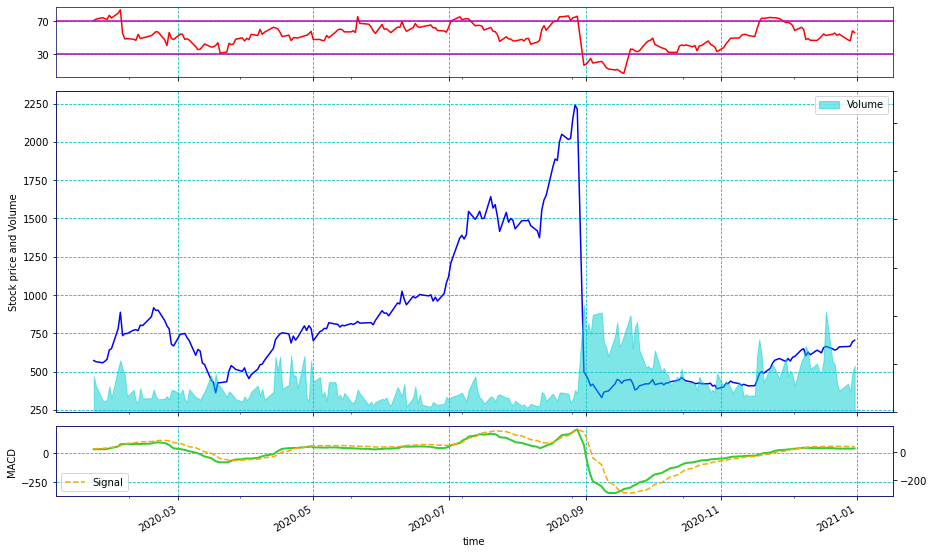

In [26]:
# Write a method to filter on one ticker and retrieve all the information for this tickers : ohlcv - RSI - MACD+Signal
def display_technical_chart(ticker, ohlcv, rsi, macd, start_date, end_date):
    '''Ploting chart
        Returns 3 charts: RSI, Price/volume and MACD
    
        Parameters
        ----------
        ticker : str() - symbol of teh ticker we select
        ohlcv : pd.DataFrame - initial dataframe to be processed with open / high / low / close / volume
        rsi : pd.DataFrame - dataframe to be processed with RSI
        macd : pd.DataFrame - dataframe to be processed with MACD

        start_date : str() - string with date in following format YYYY-MM-DD
        end_date : str() - string with date in following format YYYY-MM-DD
    
        Returns
        -------
        3 charts
    '''
    
    
    ############# create a new DF filtered on one ticker ###############
    
    # Swap column levels for RSI_DF and MACD_DF to make sure we have the ticker in level 0
    rsi_df= rsi.swaplevel(0,1,axis=1)
    
    
    rsi_df_sliced= rsi_df.loc[start_date:end_date,ticker]
    macd_df= macd.swaplevel(0,1,axis=1)
    macd_df_sliced= macd_df.loc[start_date:end_date,ticker]
    ohlcv_df_sliced=ohlcv.loc[start_date:end_date,ticker]
    
    # Concat the dfs
    chart_ta_df = pd.concat([ohlcv_df_sliced, rsi_df_sliced, macd_df_sliced], axis=1, join='inner')

    
    #################### Chart ######################
    
    
    # Create the figure
    fig = plt.figure(figsize=(15,10))
   
    # Create the first subplot = Price
    ax1 = plt.subplot2grid((6,4), (1,0), rowspan=4, colspan=4)
    ax1 = chart_ta_df['close'].plot(color='b', label='Price')
    ax1.grid(True, color='c', linestyle='--')
    ax1.yaxis.label.set_color("k")
    ax1.tick_params(axis='y', colors='k')
    ax1.tick_params(axis='x', colors='k')
    ax1.set_facecolor('w')
    plt.ylabel('Stock price and Volume')
   
    # Add the volume within the same subplot
    # Retrieve volumes into a list
    volume = chart_ta_df['volume']
    # Share the same x-axis
    ax1v= ax1.twinx()
    ax1v.fill_between(chart_ta_df.index, volume,0, color='darkturquoise', alpha=0.5, label='Volume')
    # To avoid having a second grid overlaping the first one
    ax1v.grid(False)
    # Set the limit for the second y-axis and make it look smaller by multiplying the max volume
    ax1v.set_ylim(0, 3*volume.max())
    ax1v.axes.yaxis.set_ticklabels([])
    ax1v.tick_params(axis='y', colors='k')
    ax1v.yaxis.label.set_color("k")
    ax1v.spines['bottom'].set_color('midnightblue')
    ax1v.spines['top'].set_color('midnightblue')
    ax1v.spines['left'].set_color('midnightblue')
    ax1v.spines['right'].set_color('midnightblue')
    ax1v.legend()

    # Create a second subplot for the RSI
    ax0 = plt.subplot2grid((6,4), (0,0), sharex=ax1, rowspan=1, colspan=4)      
    ax0 = chart_ta_df['RSI'].plot(color='r')
    ax0.axhline(70, color='m')
    ax0.axhline(30, color='m')
    ax0.set_yticks([30,70])
    ax0.yaxis.label.set_color("w")
    ax0.tick_params(axis='y', colors='k')
    ax0.tick_params(axis='x', colors='k')
    ax0.grid(True, color='c', linestyle='--')
    ax0.set_facecolor('w')
    ax0.spines['bottom'].set_color('midnightblue')
    ax0.spines['top'].set_color('midnightblue')
    ax0.spines['left'].set_color('midnightblue')
    ax0.spines['right'].set_color('midnightblue')
    plt.ylabel('RSI')

    # Create a third subplot for the MACD
    ax2= plt.subplot2grid((6,4), (5,0), sharex=ax1, rowspan=1, colspan=4)
    ax2= chart_ta_df['MACD'].plot(color='limegreen', linewidth=2, label='MACD')
    ax2.tick_params(axis='x', colors='k')
    ax2.tick_params(axis='y', colors='k')
    ax2.grid(True, color='c', linestyle='--')
    ax2.set_facecolor('w')
    ax2.spines['bottom'].set_color('midnightblue')
    ax2.spines['top'].set_color('midnightblue')
    ax2.spines['left'].set_color('midnightblue')
    ax2.spines['right'].set_color('midnightblue')
    plt.ylabel('MACD', color='k')
   
    # Add the Signal line to the same subplot
    # share the same x-axis
    ax_signal= ax2.twinx()
    ax_signal= chart_ta_df['MACD_Signal'].plot(color='orange',linestyle='--', label='Signal')
    ax_signal.spines['bottom'].set_color('midnightblue')
    ax_signal.spines['top'].set_color('midnightblue')
    ax_signal.spines['left'].set_color('midnightblue')
    ax_signal.spines['right'].set_color('midnightblue')
    plt.legend()

    return fig




# Display chart at load
stock_prices_for_technical_chart = stock_prices_from_api(["TSLA"],
                                                        "2020-01-01",
                                                        "2021-01-01")

rsi_df = rsi_table(stock_prices_for_technical_chart, 14)

macd_df = macd_table(stock_prices_for_technical_chart, 12, 26, 9)

technical_chart_panel = pn.pane.Matplotlib(display_technical_chart('TSLA', 
                                                         stock_pices_for_technical_chart, 
                                                         rsi_df, 
                                                         macd_df,
                                                         "2020-01-01",
                                                         "2021-01-01"))



    
# Apply the chart generator method
btn_update_technical_indicators_charton_click = pn.widgets.Button(name='View Technical Indicators', button_type='primary')

def apply_update_technical_indicators_chart(event):
    
    _stock_prices_for_technical_chart = stock_prices_from_api([str(select_ticker_for_technical_display.value)],
                                                        str(datepicker_date_start_date_selector.value),
                                                        str(datepicker_date_end_date_selector.value))

    rsi_df = rsi_table(_stock_prices_for_technical_chart, 14)

    macd_df = macd_table(_stock_prices_for_technical_chart, 12, 26, 9)
    
    updated_chart = display_technical_chart(str(select_ticker_for_technical_display.value), 
                                            _stock_prices_for_technical_chart, 
                                            rsi_df, 
                                            macd_df,
                                            str(datepicker_date_start_date_selector.value),
                                            str(datepicker_date_end_date_selector.value))
    
    technical_chart_panel.object = updated_chart
    
    
# Reset chart
btn_update_technical_indicators_charton_click.on_click(apply_update_technical_indicators_chart)

# Stock dropdown menu
select_ticker_for_technical_display = pn.widgets.Select(name='Ticker', options=list(sp500_tickers["Symbol"]))

# Update select_ticker_for_technical
def update_select_ticker_for_technical_display():
    select_ticker_for_technical_display.options = list(fundamental_stocks_dataframe.index.values)

#### Filter Tab Builder

In [27]:
# Stock filter tab
filter_tab = pn.Row(
    pn.Column(
        "## Model portfolio builder",
        # Date range selector
        pn.Row("#### Select date range for model portfolio:", datepicker_date_start_date_selector, datepicker_date_end_date_selector),
        pn.layout.Divider(margin=(-0, 0, 0, 0)),

        
        # Fundamental analysis filter area
        fundamental_filter_title,
        pn.Row(
            # Criteria selection via textbox entry
            pn.Column(
                pn.panel("#### Selection criteria"),
                
                # Gridbox with selection criteria text fields and descriptors
                pn.GridBox(
                    pn.panel("P/E - price / earnings", style={'font-weight' : 'bold'}),
                    pn.Row(text_input_min_pe_values, text_input_max_pe_values, width_policy='max'),

                    pn.panel("EPS - earnings per share", style={'font-weight' : 'bold'}),
                    pn.Row(text_input_min_eps_values, text_input_max_eps_values, width_policy='max'),

                    pn.panel("Dividend per share", style={'font-weight' : 'bold'}),
                    pn.Row(text_input_min_dividend_values, text_input_max_dividend_values, width_policy='max'),
                ncols = 2,
                width_policy='fit'
            ),
            # Button to excecute filter and reset filter functions
            pn.panel(btn_update_fundamental_stocks_dataframe_viewer),
            pn.panel(btn_reset_fundamental_stocks_dataframe_viewer),
                width_policy='fit'),
            
            # Display of selected stocks
            pn.Column(pn.panel(f"#### Filtered Stocks"), 
                  pn.Row(fundamental_stocks_dataframe_viewer,height = 100, sizing_mode='stretch_both'),
                      width_policy='fit'),
            width_policy='fit'),
          pn.layout.Divider(margin=(-0, 0, 0, 0)),
        
        
        
        # Technical analysis filter area
        pn.Column(
            technical_filter_title,
            pn.Row(
                pn.GridBox(pn.panel("RSI Trader - Technical portfolio simulator", style={'font-weight' : 'bold'}),
                       pn.panel("RSI (Relative Strenght Index) indicates when a security is overbought or oversold"),
                       pn.Row(text_input_min_rsi_values, text_input_max_rsi_values, text_input_rsi_lenght)
                      ),
                btn_apply_rsi_simualted_portfolio
        )
        )
    
    ),
    # Plot portfolio return
    pn.Column(fundamental_technical_portfolio_plot_panel)
)

In [28]:
# Technical analysis tab
technical_tab = pn.Row(
    pn.Column(
        select_ticker_for_technical_display,
        btn_update_technical_indicators_charton_click
    ),
    pn.Column(pn.Spacer(background=background_color, sizing_mode='stretch_both')),
    pn.Column("## Price, Volume, RSI and MACD",
        technical_chart_panel)
)

#### Dashboard Tabs

In [29]:
powerfolio_dash = pn.Column(
    pn.panel(title_panel, width=600),
    pn.Tabs(
        ("Welcome to Powerfolio!", welcome_to_powerfolio),
        ("Fundamental/Technical Portfolio Builder", filter_tab),
        ("Technical Analysis", technical_tab),
        ("Efficient Frontier", "Sharpe Ratio"),
        ("Hierarchical Clustering", "Hierarchical Clustering")
    )
)

powerfolio_dash.show()

Launching server at http://localhost:54449
